Epoch [1/3]  D Loss: 1.4032  G Loss: 1.4023
Epoch [2/3]  D Loss: 0.9303  G Loss: 1.3175
Epoch [3/3]  D Loss: 1.3815  G Loss: 0.9826


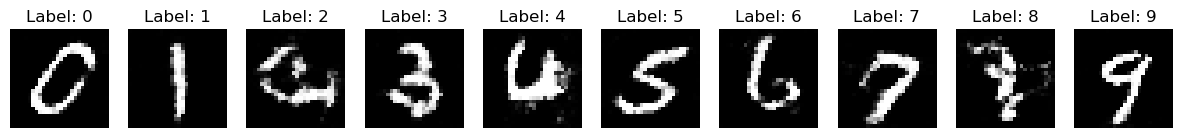

In [53]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# 디바이스 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 데이터셋 로드
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
mnist_data = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
data_loader = DataLoader(mnist_data, batch_size=128, shuffle=True)

# 조건부 생성자 (Generator)
class Generator(nn.Module):
    def __init__(self, noise_dim, label_dim, img_channels):
        super(Generator, self).__init__()
        self.label_embedding = nn.Embedding(10, label_dim)
        self.layers = nn.Sequential(
            nn.ConvTranspose2d(noise_dim + label_dim, 256, kernel_size=3, stride=1, padding=0),  # Output: (256, 3, 3)
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),  # Output: (128, 6, 6)
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # Output: (64, 12, 12)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, img_channels, kernel_size=8, stride=2, padding=1),  # Output: (1, 28, 28)
            nn.Tanh()
        )

    def forward(self, noise, labels):
        labels_embedded = self.label_embedding(labels).unsqueeze(2).unsqueeze(3)
        input = torch.cat((noise, labels_embedded), dim=1)
        x = self.layers(input)
        return x




# 조건부 판별자 (Discriminator)
class Discriminator(nn.Module):
    def __init__(self, img_channels, label_dim):
        super(Discriminator, self).__init__()
        self.label_embedding = nn.Embedding(10, label_dim)
        self.model = nn.Sequential(
            nn.Conv2d(img_channels + label_dim, 64, 4, 2, 1),  # Output: (64, 14, 14)
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, 4, 2, 1),  # Output: (128, 7, 7)
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, 4, 2, 1),  # Output: (256, 3, 3)
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.Conv2d(256, 1, 3, 1, 0),  # Output: (1, 1, 1)
            nn.Sigmoid()
        )

    def forward(self, img, labels):
        # label_embedding(labels) 는 크기가 10인 벡터 (batch_size, 10)
        labels_embedded = self.label_embedding(labels).unsqueeze(2).unsqueeze(3) # (batch_size, 10, 1, 1)
        # (labels_embedded.size(0), labels_embedded.size(1), img.size(2), img.size(3)) = (batch_sizi, 10, 28, 28)
        labels_embedded = labels_embedded.expand(labels_embedded.size(0), labels_embedded.size(1), img.size(2), img.size(3))
        input = torch.cat((img, labels_embedded), dim=1) # (batch_size, 11, 28, 28)
        return self.model(input).view(-1, 1)

# 모델 초기화
noise_dim = 100
label_dim = 10
img_channels = 1
G = Generator(noise_dim, label_dim, img_channels).to(device)
D = Discriminator(img_channels, label_dim).to(device)

# 손실 함수 및 옵티마이저
criterion = nn.BCELoss()
optimizer_G = optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))

# 학습
epochs = 3
for epoch in range(epochs):
    for imgs, labels in data_loader:
        imgs, labels = imgs.to(device), labels.to(device)

        # 진짜 이미지와 레이블
        real_labels = torch.ones(imgs.size(0), 1).to(device)
        fake_labels = torch.zeros(imgs.size(0), 1).to(device)

        # ---------------------
        # 1. 판별자 학습
        # ---------------------
        optimizer_D.zero_grad()
        noise = torch.randn(imgs.size(0), noise_dim, 1, 1).to(device)
        gen_labels = torch.randint(0, 10, (imgs.size(0),)).to(device)
        gen_imgs = G(noise, gen_labels)

        real_loss = criterion(D(imgs, labels), real_labels)
        fake_loss = criterion(D(gen_imgs.detach(), gen_labels), fake_labels)
        d_loss = real_loss + fake_loss
        d_loss.backward()
        optimizer_D.step()

        # ---------------------
        # 2. 생성자 학습
        # ---------------------
        optimizer_G.zero_grad()
        gen_loss = criterion(D(gen_imgs, gen_labels), real_labels)
        gen_loss.backward()
        optimizer_G.step()

    print(f"Epoch [{epoch+1}/{epochs}]  D Loss: {d_loss.item():.4f}  G Loss: {gen_loss.item():.4f}")

# 생성 결과 샘플
G.eval()
with torch.no_grad():
    noise = torch.randn(10, noise_dim, 1, 1).to(device)
    labels = torch.arange(10).to(device)
    gen_imgs = G(noise, labels).cpu()

fig, axs = plt.subplots(1, 10, figsize=(15, 3))
for i in range(10):
    axs[i].imshow(gen_imgs[i].squeeze(0), cmap='gray')
    axs[i].set_title(f"Label: {i}")
    axs[i].axis('off')
plt.show()

In [55]:
# nn.Embedding 정의 (2개의 임베딩, 각 임베딩의 차원은 3)
embedding = nn.Embedding(2, 3)

# 초기 임베딩 가중치 확인
print("Initial weights:")
print(embedding.weight)

# 정수 입력 정의 (0 또는 1만 가능)
input_indices = torch.tensor([0, 1, 0])

# 임베딩 레이어 통과
output = embedding(input_indices)

print("\nInput indices:")
print(input_indices)
print("\nEmbedding output:")
print(output)

Initial weights:
Parameter containing:
tensor([[ 0.1660, -1.1160,  1.3608],
        [-2.4057, -0.2664,  1.1842]], requires_grad=True)

Input indices:
tensor([0, 1, 0])

Embedding output:
tensor([[ 0.1660, -1.1160,  1.3608],
        [-2.4057, -0.2664,  1.1842],
        [ 0.1660, -1.1160,  1.3608]], grad_fn=<EmbeddingBackward0>)
